# Import library

In [1]:
import pickle
import pandas as pd
import warnings
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import silhouette_score,silhouette_samples
from sklearn.metrics import calinski_harabasz_score
from scipy.cluster.hierarchy import cophenet
from sklearn.metrics import pairwise_distances
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import MDS
import umap
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans
from sklearn.cluster import AgglomerativeClustering
from tqdm import tqdm
from sklearn.cluster import DBSCAN
from joblib import Parallel, delayed
import matplotlib.cm as cm
from sklearn.utils import resample

# Set Seaborn style
sns.set()
warnings.filterwarnings("ignore")

# Load data

In [2]:
def load_data(filename):
    # Load the TF-IDF vectorizer
    file = open('Data/tfidf_vectorizer_train_split_33k.pkl', 'rb')
    tfidf = pickle.load(file)

    # Read the data from the file
    cfpb_df = pd.read_csv(filename)

    # Analyze only the Debt collection column data for its sub_product
    cfpb_df = cfpb_df[cfpb_df['Product'] == 'Debt collection']
    
    cfpb_df = cfpb_df
    
    # Get all unique sub-products
    unique_sub_products = cfpb_df['Sub-product'].unique()

    for i, sub_product in enumerate(unique_sub_products):
        print(f"Category {i+1}: {sub_product}")

    # Transform the data using TF-IDF vectorizer
    X = tfidf.fit_transform(cfpb_df['Consumer complaint narrative'])
    
    return X, cfpb_df['Sub-product']

# Inspect data

In [3]:
X_, y = load_data('Data/cfpb_train.csv')
print(X_.shape)

Category 1: I do not know
Category 2: Auto
Category 3: Credit card debt
Category 4: Other debt
Category 5: Federal student loan debt
Category 6: Medical debt
Category 7: Credit card
Category 8: Auto debt
Category 9: Payday loan
Category 10: Other (i.e. phone, health club, etc.)
Category 11: Medical
Category 12: Payday loan debt
Category 13: Mortgage debt
Category 14: Private student loan debt
Category 15: Mortgage
Category 16: Non-federal student loan
Category 17: Federal student loan
(146049, 30288)


In [4]:
first_row = X_[0, :]  # X_ is sparse matrix
print(first_row)


  (0, 29076)	0.19812224216639168
  (0, 29050)	0.16356325304542552
  (0, 28896)	0.1561576286372036
  (0, 28410)	0.25776365346848285
  (0, 27507)	0.1824724268482809
  (0, 26683)	0.17986263285204018
  (0, 24713)	0.20488097557963178
  (0, 21076)	0.22811065130062
  (0, 18929)	0.2147264639696369
  (0, 18044)	0.17763408341195971
  (0, 17465)	0.21728787476059486
  (0, 16474)	0.22797984109901945
  (0, 14982)	0.2265765843605686
  (0, 10030)	0.179110494924432
  (0, 8802)	0.1781440693196934
  (0, 8179)	0.15548697557891283
  (0, 8176)	0.09996288560528886
  (0, 5513)	0.22152904083312633
  (0, 5377)	0.1946300432076677
  (0, 5373)	0.0925929783330986
  (0, 4523)	0.250169700125912
  (0, 4384)	0.2634253673703271
  (0, 4352)	0.22174132504222485
  (0, 2793)	0.21220604477750796
  (0, 1683)	0.1887598682850692


In [5]:
# merge target y and X_into one DataFrame
# Sparse matrix to array
data = pd.DataFrame(X_.toarray())
data['Sub-product'] = y

#sample from each sub-product
sampled_data = pd.DataFrame()
unique_sub_products = data['Sub-product'].unique()
for sub_product in unique_sub_products:
    sub_data = data[data['Sub-product'] == sub_product]
    num_samples = min(len(sub_data), 100)  
    sampled_sub_data = sub_data.sample(n=num_samples, random_state=2023)
    sampled_data = pd.concat([sampled_data, sampled_sub_data])


X_1 = sampled_data.iloc[:, :-1].values
y_1 = sampled_data['Sub-product'].values

In [6]:
X_1.shape

(1649, 30288)

In [7]:
from sklearn.preprocessing import MinMaxScaler

#Standardized for PCA
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_1)


# Demensionality Reduction

## Applying PCA on data

### PCA evaluation

In [8]:
import numpy as np
covariance_matrix = np.cov(X_scaled.T)
pca = PCA()
pca.fit(X_scaled)
# to identify optimal dimension
cumulative_variance_ratio = np.cumsum(pca.explained_variance_ratio_)

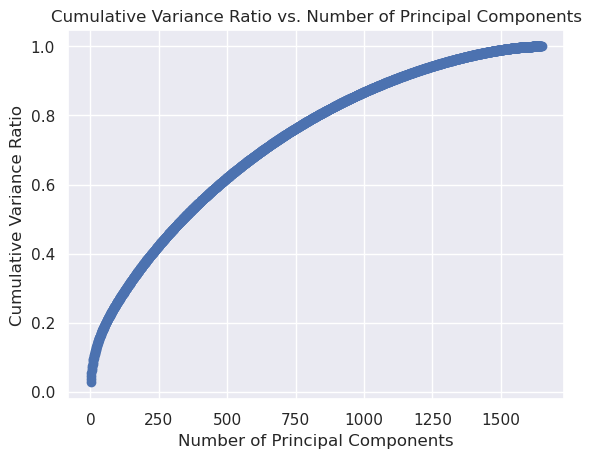

In [9]:
plt.plot(range(1, len(cumulative_variance_ratio) + 1), cumulative_variance_ratio, 'bo-')
plt.rcParams['lines.linewidth'] = 0.01
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Variance Ratio')
plt.title('Cumulative Variance Ratio vs. Number of Principal Components')
plt.grid(True)
plt.show()

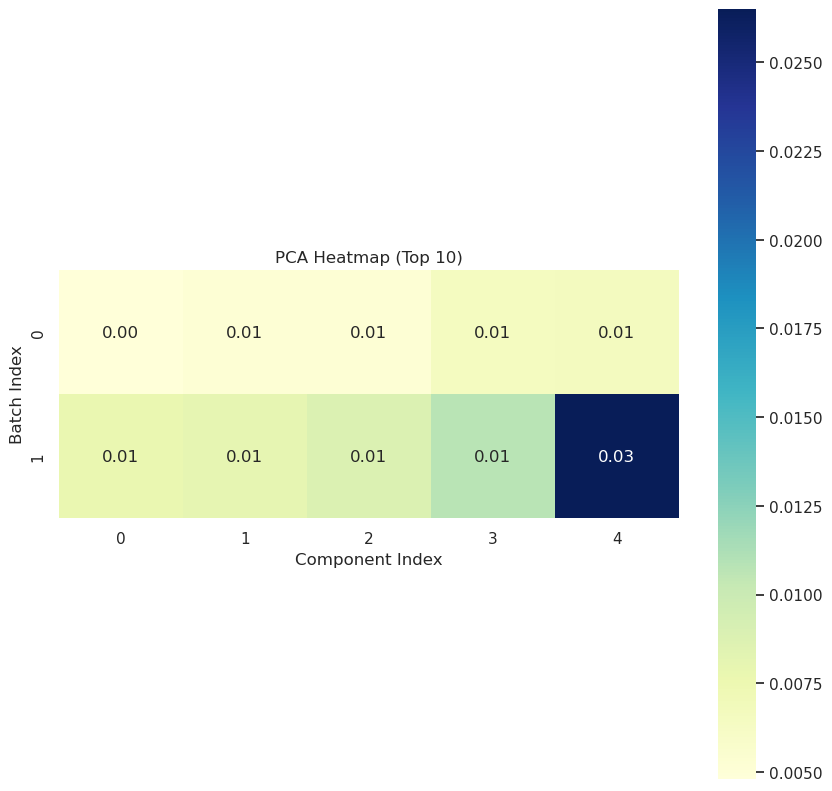

In [10]:
import seaborn as sns


sns.set(style="white")
explained_variance_ratio = pca.explained_variance_ratio_

# Top 10 PCA
top_10_indices = np.argsort(explained_variance_ratio)[-10:]
heatmap_data = np.reshape(explained_variance_ratio[top_10_indices], (-1, 5))

# Heatmap for visual
plt.figure(figsize=(10, 10))
sns.heatmap(heatmap_data, cmap='YlGnBu', annot=True, fmt=".2f", cbar=True, square=True)
plt.xlabel('Component Index')
plt.ylabel('Batch Index')
plt.title('PCA Heatmap (Top 10)')
plt.show()


We could see that only when dimensionality 800, it achieves 0.8 cum var ratio. Besides, PC1 and PC2 still captures
only very very little variation. PCA may not be a suitable DR technique.

In [11]:
n_components = 800
pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(X_scaled)

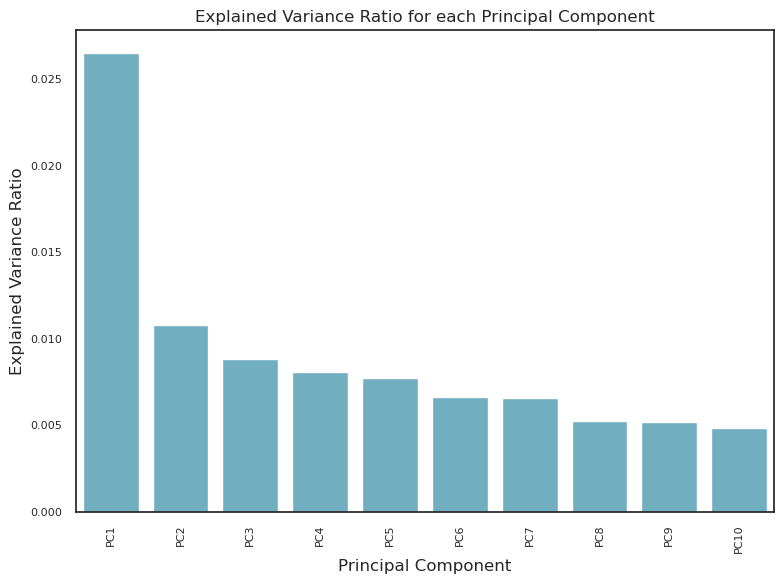

In [12]:
num_components = len(pca.explained_variance_ratio_)
df = pd.DataFrame({'explained var ratio': pca.explained_variance_ratio_,
                  'PC': [f'PC{i+1}' for i in range(num_components)]})
fig, ax = plt.subplots(figsize=(8, 6))
n_components_to_show = 10  # plot out only first 10 PC
df1_subset = df[:n_components_to_show]

sns.barplot(x='PC', y='explained var ratio', data=df1_subset, color='c', ax=ax)
ax.set_xticklabels(ax.get_xticklabels()[:n_components_to_show], rotation=90)  
ax.tick_params(axis='both', labelsize=8)

ax.set_xlabel('Principal Component')
ax.set_ylabel('Explained Variance Ratio')
ax.set_title('Explained Variance Ratio for each Principal Component')

plt.tight_layout()
plt.show()


### 2-D projection of Data using PCA

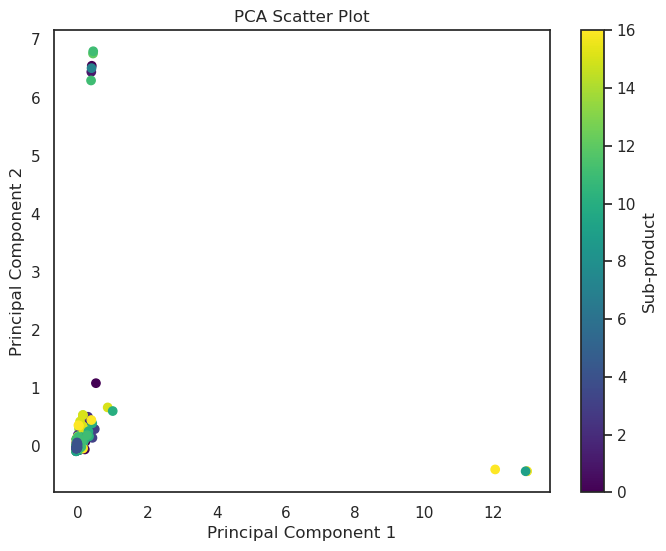

In [13]:
from sklearn.preprocessing import LabelEncoder

# encode y subset
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y_1)

plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_encoded, cmap='viridis')
plt.xlabel('Principal Component 1')  
plt.ylabel('Principal Component 2')
plt.title('PCA Scatter Plot')
plt.colorbar(label='Sub-product')
plt.show()

# Kmeans clustering 

## Kmeans using PCA as DR

### Elbow Method Analysis on selecting optimal number of clusters

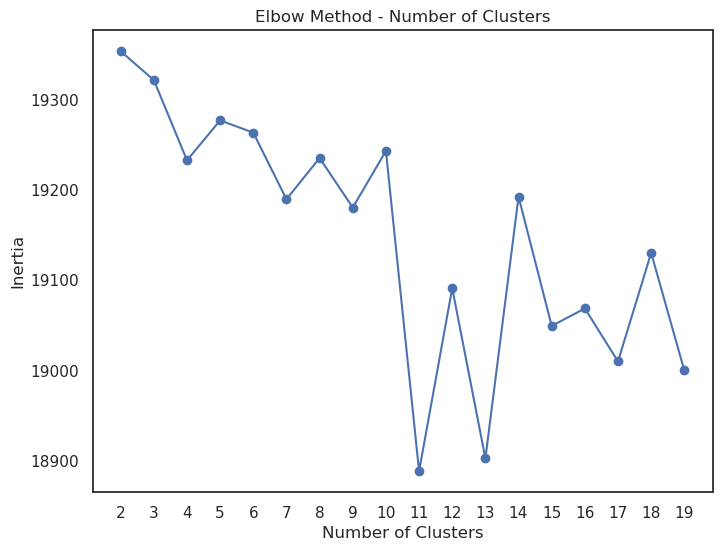

In [14]:
cluster_range = range(2, 20)
inertia = [] 

for n_clusters in cluster_range:
    kmeans = MiniBatchKMeans(n_clusters=n_clusters, batch_size=100, random_state=2023)
    kmeans.fit(X_pca)
    inertia.append(kmeans.inertia_)


plt.figure(figsize=(8, 6))
plt.plot(list(cluster_range), inertia, marker='o')
plt.xticks(list(cluster_range))
plt.xlabel('Number of Clusters')
plt.ylabel('WGSS')
plt.title('Elbow Method - Number of Clusters')
plt.show()


In [ ]:
### optimal n=4 

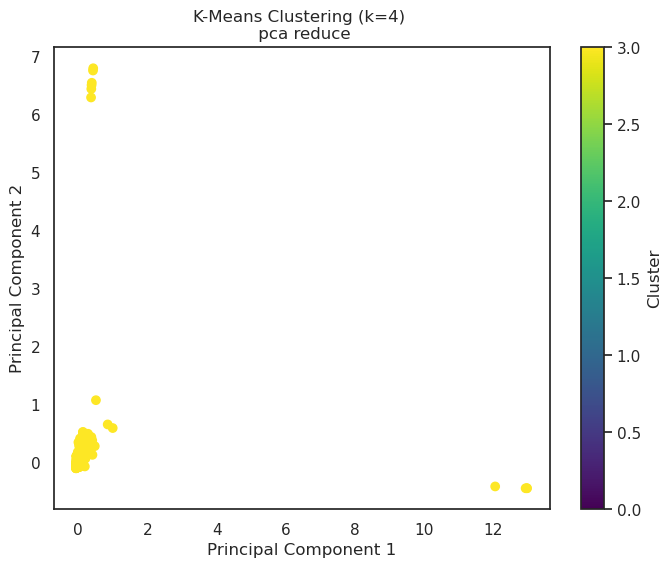

In [15]:
n_clusters = 4
kmeans = MiniBatchKMeans(n_clusters=n_clusters, batch_size=10, random_state=2023)
kmeans.fit(X_pca)

# get cluster membership
labels = kmeans.labels_

# plot
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='viridis')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title(f'K-Means Clustering (k={n_clusters}) \n pca reduce')
plt.colorbar(label='Cluster')
plt.show()


### Model evaluation (using PCA as RD- not performing well)

In [16]:
from sklearn.metrics import silhouette_score
from sklearn.metrics import davies_bouldin_score

# silhouette score, closer to 1 better in [-1, 1]
silhouette_avg = silhouette_score(X_pca, labels)
print(f"Silhouette Coefficient: {silhouette_avg}")
# Calinski-Harabasz score, higher better
calinski_score = calinski_harabasz_score(X_pca, labels)
print(f"Calinski-Harabasz Index: {calinski_score}")
# Davies-Bouldin score, lower better
davies_bouldin = davies_bouldin_score(X_pca, labels)
print("Davies-Bouldin Score:", davies_bouldin)

Silhouette Coefficient: -0.15158791134208965
Calinski-Harabasz Index: 1.0662878906979625
Davies-Bouldin Score: 1.036897443816167


## Applying UMAP on data

### 2D projection of data using UMAP

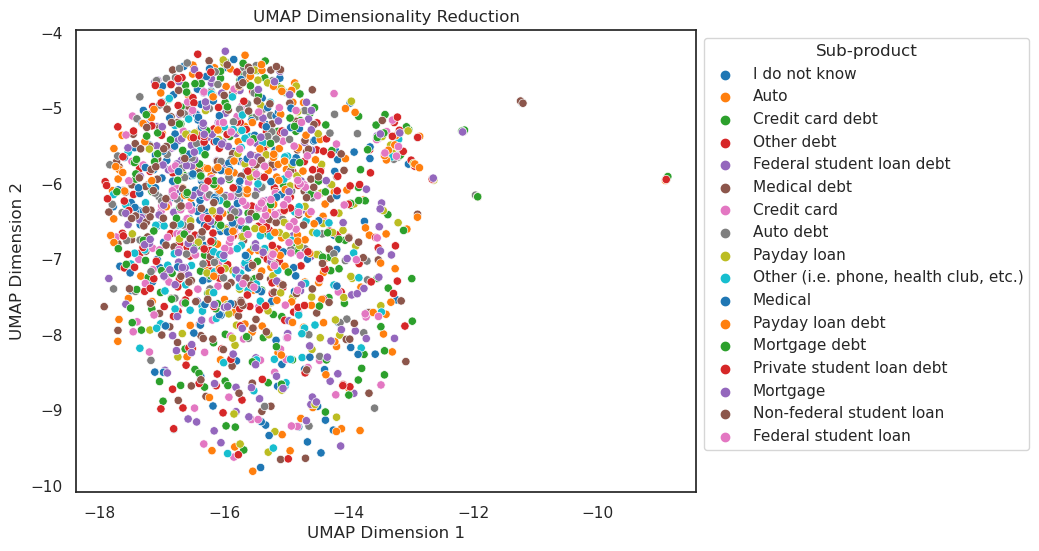

In [17]:
# umap
import umap.umap_ as umap
n_components = 2  # reduce to 2-D for 2-D visualization
umap_model = umap.UMAP(n_components=n_components)
X_umap = umap_model.fit_transform(X_scaled)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_umap[:, 0], y=X_umap[:, 1], hue=y_1, palette='tab10')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.title('UMAP Dimensionality Reduction')
plt.legend(title='Sub-product', bbox_to_anchor=(1, 1), loc='upper left')
plt.show()


## kmeans clustering using UMAP as DR

### Silhouette Score Analysis on selecting optimal number of clusters

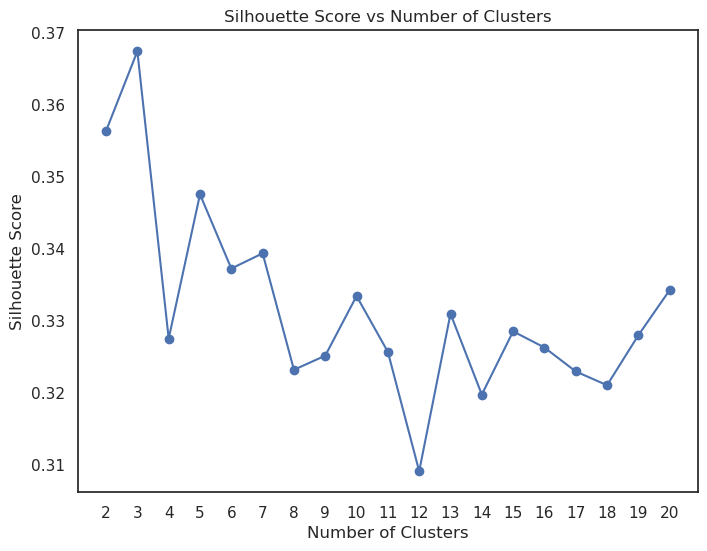

In [18]:
max_clusters = 20
silhouette_scores = []

for n_clusters in range(2, max_clusters+1):
    kmeans = MiniBatchKMeans(n_clusters=n_clusters, random_state=2023)
    kmeans.fit(X_umap)
    labels = kmeans.labels_
    silhouette_scores.append(silhouette_score(X_umap, labels))


plt.figure(figsize=(8, 6))
plt.plot(np.arange(2, max_clusters+1), silhouette_scores, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs Number of Clusters')
plt.xticks(np.arange(2, max_clusters+1), np.arange(2, max_clusters+1))
plt.show()



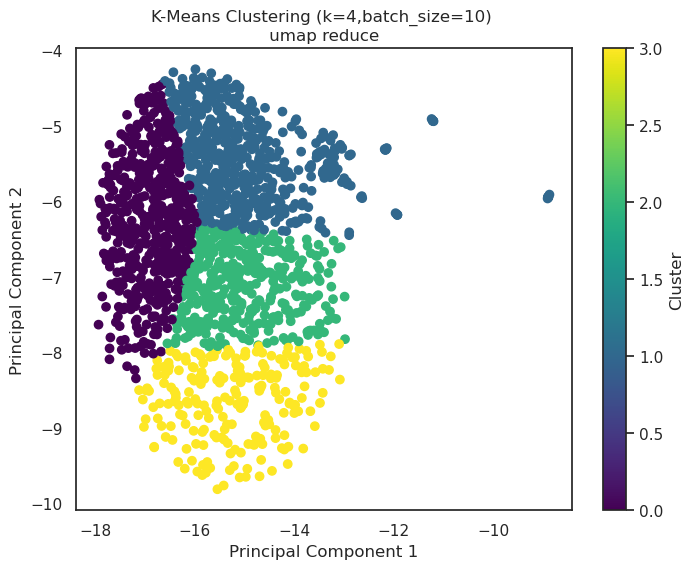

In [19]:

n_clusters = 4
batch_size=10 
kmeans = MiniBatchKMeans(n_clusters=n_clusters, batch_size=batch_size, random_state=2023)
kmeans.fit(X_umap)

# cluster membership
labels = kmeans.labels_

# plot
plt.figure(figsize=(8, 6))
plt.scatter(X_umap[:, 0], X_umap[:, 1], c=labels, cmap='viridis')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.title(f'K-Means Clustering (k={n_clusters},batch_size={batch_size}) \n umap reduce ')
plt.colorbar(label='Cluster')
plt.show()


### Model Evaluation

In [20]:

from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

silhouette_avg = silhouette_score(X_umap, labels)
print("Silhouette Coefficient:", silhouette_avg)

calinski_harabasz = calinski_harabasz_score(X_umap, labels)
print("Calinski-Harabasz Score:", calinski_harabasz)

davies_bouldin = davies_bouldin_score(X_umap, labels)
print("Davies-Bouldin Score:", davies_bouldin)


Silhouette Coefficient: 0.29604647
Calinski-Harabasz Score: 803.8306270384675
Davies-Bouldin Score: 1.1195984324382433


## Sensitivity Analysis on Kmeans - hyperparemeter exploration

In [21]:
# since optimal n_clusters = 4 was selected, traverse around 4
n_clusters_range = [2, 3, 4, 5, 6]  #k's range
batch_size_range = [5, 10, 50, 100]  #MiniBatchKMeans's batch_size

best_score = -1  
best_params = {}  

# loop through range of parameters: n_cluster and batch_size
for n_clusters in n_clusters_range:
    for batch_size in batch_size_range:
        kmeans = MiniBatchKMeans(n_clusters=n_clusters, batch_size=batch_size, random_state=2023)
        kmeans.fit(X_umap)
        labels = kmeans.labels_
        score = silhouette_score(X_umap, labels)
        
        print(f"n_clusters={n_clusters}, batch_size={batch_size}, silhouette score={score}")
        
        
        if score > best_score:
            best_score = score
            best_params['n_clusters'] = n_clusters
            best_params['batch_size'] = batch_size

# print out the best parameter combinations with silhouette score
print("Best Parameters:")
print(best_params)
print("Best Silhouette Score:", best_score)


n_clusters=2, batch_size=5, silhouette score=0.35645678639411926
n_clusters=2, batch_size=10, silhouette score=0.3141879737377167
n_clusters=2, batch_size=50, silhouette score=0.3571697473526001
n_clusters=2, batch_size=100, silhouette score=0.34927496314048767
n_clusters=3, batch_size=5, silhouette score=0.3553828001022339
n_clusters=3, batch_size=10, silhouette score=0.360735684633255
n_clusters=3, batch_size=50, silhouette score=0.369108647108078
n_clusters=3, batch_size=100, silhouette score=0.35811346769332886
n_clusters=4, batch_size=5, silhouette score=0.3447640836238861
n_clusters=4, batch_size=10, silhouette score=0.2960464656352997
n_clusters=4, batch_size=50, silhouette score=0.3370036482810974
n_clusters=4, batch_size=100, silhouette score=0.3363671600818634
n_clusters=5, batch_size=5, silhouette score=0.3159375786781311
n_clusters=5, batch_size=10, silhouette score=0.31263887882232666
n_clusters=5, batch_size=50, silhouette score=0.3398769199848175
n_clusters=5, batch_size

### Heatmap visualization of hyperparameter combinations

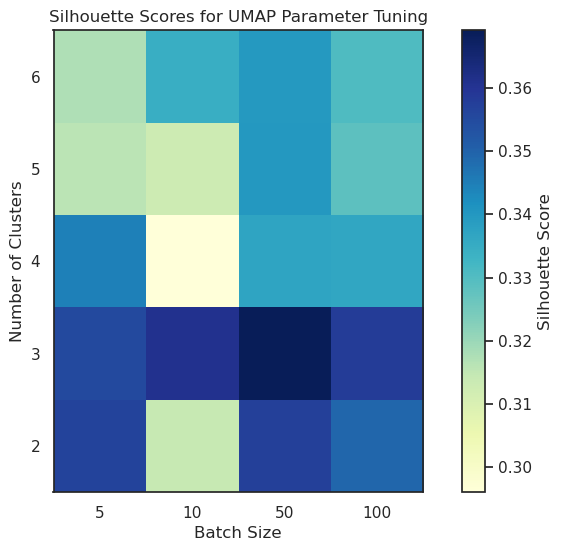

In [22]:

n_clusters_range = [2, 3, 4, 5, 6]
batch_size_range = [5, 10, 50, 100]


silhouette_scores = []

for n_clusters in n_clusters_range:
    for batch_size in batch_size_range:
        kmeans = MiniBatchKMeans(n_clusters=n_clusters, batch_size=batch_size, random_state=2023)
        kmeans.fit(X_umap)
        labels = kmeans.labels_
        score = silhouette_score(X_umap, labels)
        
        silhouette_scores.append(score)


silhouette_scores = np.array(silhouette_scores).reshape(len(n_clusters_range), len(batch_size_range))

# darker color is better combination
plt.figure(figsize=(10, 6))
plt.imshow(silhouette_scores, cmap='YlGnBu', origin='lower')
plt.colorbar(label='Silhouette Score')
plt.xticks(np.arange(len(batch_size_range)), batch_size_range)
plt.yticks(np.arange(len(n_clusters_range)), n_clusters_range)
plt.xlabel('Batch Size')
plt.ylabel('Number of Clusters')
plt.title('Silhouette Scores for UMAP Parameter Tuning')
plt.show()


### Visualization of Clusters output with kmeans optimal parameters

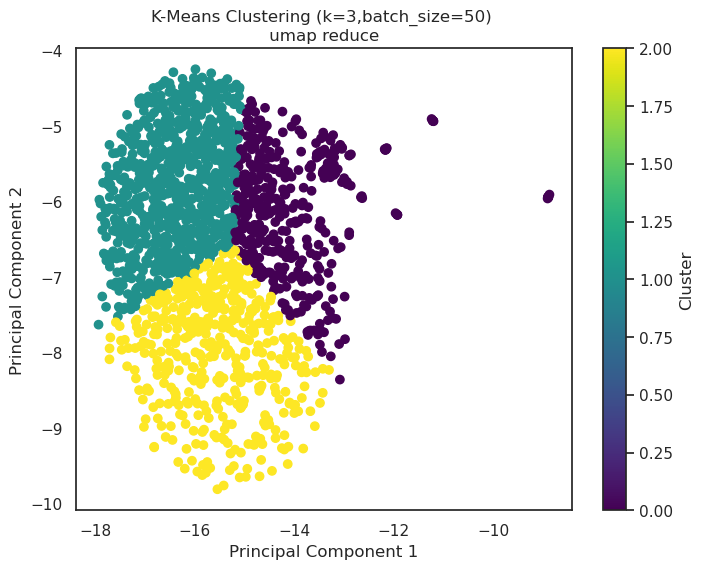

In [23]:
n_clusters = 3
batch_size = 50
kmeans = MiniBatchKMeans(n_clusters= n_clusters, batch_size= batch_size, random_state=2023)
kmeans.fit(X_umap)

labels = kmeans.labels_

# plot
plt.figure(figsize=(8, 6))
plt.scatter(X_umap[:, 0], X_umap[:, 1], c=labels, cmap='viridis')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.title(f'K-Means Clustering (k={n_clusters},batch_size={batch_size}) \n umap reduce ')
plt.colorbar(label='Cluster')
plt.show()


### Visualization of Silhouette Analysis with kmeans optimal parameters

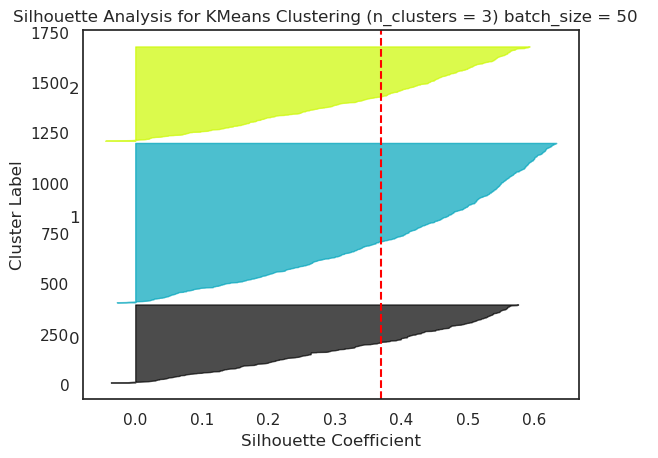

In [24]:
n= 3
score = silhouette_score(X_umap, labels)

sample_silhouette_values = silhouette_samples(X_umap, labels)

y_lower = 10
for i in range(3):
    ith_cluster_silhouette_values = sample_silhouette_values[labels == i]
    ith_cluster_silhouette_values.sort()
    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i
    color = cm.nipy_spectral(float(i) / 3)
    plt.fill_betweenx(
        np.arange(y_lower, y_upper),
        0,
        ith_cluster_silhouette_values,
        facecolor=color,
        edgecolor=color,
        alpha=0.7,
    )
    plt.text(-0.1, y_lower + 0.5 * size_cluster_i, str(i))
    y_lower = y_upper + 10

plt.title("Silhouette Analysis for KMeans Clustering (n_clusters = 3) batch_size = 50  ")
plt.xlabel("Silhouette Coefficient")
plt.ylabel("Cluster Label")
plt.axvline(x=score, color="red", linestyle="--")
plt.show()


### Model evaluation

In [25]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

silhouette_avg = silhouette_score(X_umap, labels)
print("Silhouette Coefficient:", silhouette_avg)

calinski_harabasz = calinski_harabasz_score(X_umap, labels)
print("Calinski-Harabasz Score:", calinski_harabasz)

davies_bouldin = davies_bouldin_score(X_umap, labels)
print("Davies-Bouldin Score:", davies_bouldin)


Silhouette Coefficient: 0.36910865
Calinski-Harabasz Score: 1117.638881655383
Davies-Bouldin Score: 0.8896646867061779


# Agglomerative Clustering

## Sensitivity Analysis on Agglomerative - hyperparemeter exploration

### Agglomerative Clustering using PCA as DR - best params

In [26]:
best_score = -1 
best_params = {}  

for n_clusters in range(2, 15):
    for affinity in ['euclidean', 'manhattan', 'cosine']:
        for linkage in ['ward', 'complete', 'average']:
            if linkage == 'ward' and affinity != 'euclidean':
                continue
            
            agg = AgglomerativeClustering(n_clusters=n_clusters, affinity=affinity, linkage=linkage)
            labels = agg.fit_predict(X_pca)
            score = silhouette_score(X_pca, labels)
            
            if score > best_score:
                best_score = score
                best_params = {'n_clusters': n_clusters, 'affinity': affinity, 'linkage': linkage}

print("Best Parameters:", best_params)
print("Best Silhouette Score:", best_score)


Best Parameters: {'n_clusters': 2, 'affinity': 'euclidean', 'linkage': 'ward'}
Best Silhouette Score: 0.6639631472671231


In [27]:
from sklearn.cluster import AgglomerativeClustering

agg = AgglomerativeClustering(n_clusters=2, affinity='euclidean', linkage='ward')
labels = agg.fit_predict(X_pca)

### Model evaluation

In [28]:

silhouette_avg = silhouette_score(X_pca, labels)
print("Silhouette Score:", silhouette_avg)

ch_score = calinski_harabasz_score(X_pca, labels)
print("Calinski-Harabasz Score:", ch_score)

db_score = davies_bouldin_score(X_pca, labels)
print("Davies-Bouldin Score:", db_score)


Silhouette Score: 0.6639631472671231
Calinski-Harabasz Score: 57.40173645532414
Davies-Bouldin Score: 0.319541102885369


### Visualize PCA transformed data in dendrogram

In [ ]:
from scipy.cluster.hierarchy import dendrogram, linkage

In [29]:
linkage_matrix.shape

(1648, 4)

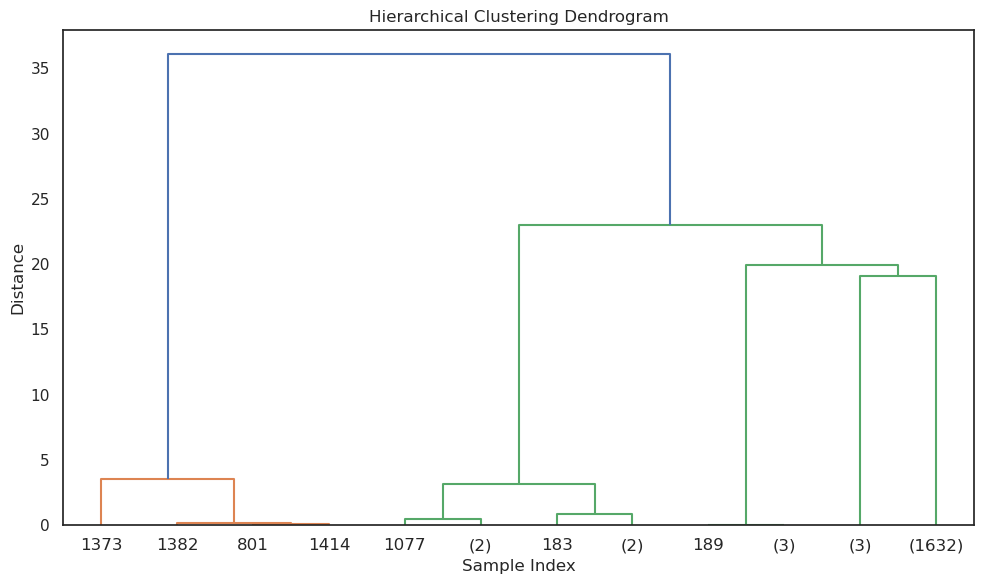

In [30]:

linkage_matrix = linkage(X_pca, method='ward')

fig, ax = plt.subplots(figsize=(10, 6))

dendrogram(linkage_matrix, ax=ax, truncate_mode='level', p=3)
ax.set_xlabel('Sample Index')
ax.set_ylabel('Distance')
ax.set_title('Hierarchical Clustering Dendrogram')

plt.tight_layout()
plt.show()


## Agglomerative Clustering using UMAP as DR - best params

In [31]:
best_score = -1  
best_params = {}  

for n_clusters in range(2, 15):
    for affinity in ['euclidean', 'manhattan', 'cosine']:
        for linkage in ['ward', 'complete', 'average']:
            if linkage == 'ward' and affinity != 'euclidean':
                continue
            
            agg = AgglomerativeClustering(n_clusters=n_clusters, affinity=affinity, linkage=linkage)
            labels = agg.fit_predict(X_umap)
            score = silhouette_score(X_umap, labels)
            
            if score > best_score:
                best_score = score
                best_params = {'n_clusters': n_clusters, 'affinity': affinity, 'linkage': linkage}

print("Best Parameters:", best_params)
print("Best Silhouette Score:", best_score)


Best Parameters: {'n_clusters': 2, 'affinity': 'euclidean', 'linkage': 'average'}
Best Silhouette Score: 0.6689829


In [32]:
agg = AgglomerativeClustering(n_clusters=2, affinity='euclidean', linkage='average')
labels = agg.fit_predict(X_umap)

### visualization of Silhouette Plot

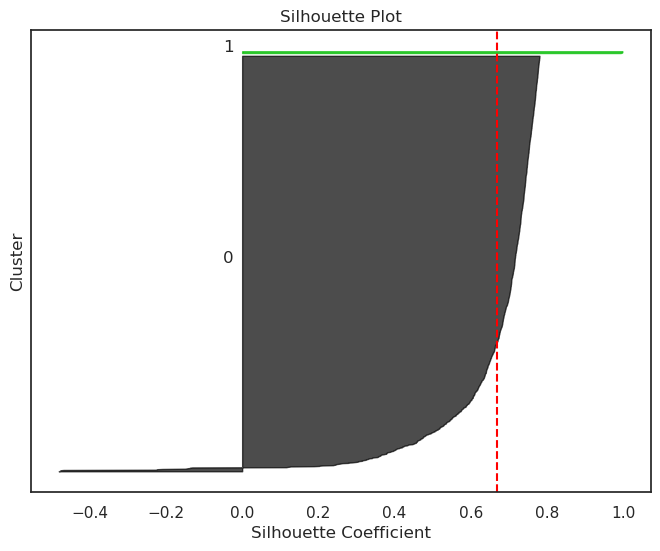

In [33]:
silhouette_vals = silhouette_samples(X_umap, labels)

silhouette_avg = silhouette_score(X_umap, labels)
fig, ax = plt.subplots(figsize=(8, 6))

y_lower = 10

for i in range(2):
    cluster_silhouette_vals = silhouette_vals[labels == i]
    cluster_silhouette_vals.sort()
   
    cluster_size = cluster_silhouette_vals.shape[0]
    y_upper = y_lower + cluster_size
    
    color = cm.nipy_spectral(float(i) / 2)
    ax.fill_betweenx(np.arange(y_lower, y_upper), 0, cluster_silhouette_vals, facecolor=color, edgecolor=color, alpha=0.7)
    
    ax.text(-0.05, y_lower + 0.5 * cluster_size, str(i))
    y_lower = y_upper + 10

ax.set_title("Silhouette Plot")
ax.set_xlabel("Silhouette Coefficient")
ax.set_ylabel("Cluster")


ax.axvline(x=silhouette_avg, color="red", linestyle="--")
ax.set_yticks([])
plt.show()

### Model evaluation

In [34]:
silhouette_avg = silhouette_score(X_umap, labels)
print("Silhouette Score:", silhouette_avg)

ch_score = calinski_harabasz_score(X_umap, labels)
print("Calinski-Harabasz Score:", ch_score)

db_score = davies_bouldin_score(X_umap, labels)
print("Davies-Bouldin Score:", db_score)



Silhouette Score: 0.6689829
Calinski-Harabasz Score: 123.67903287040873
Davies-Bouldin Score: 0.23189986917245273


### Visualize UMAP transformed data in dendrogram

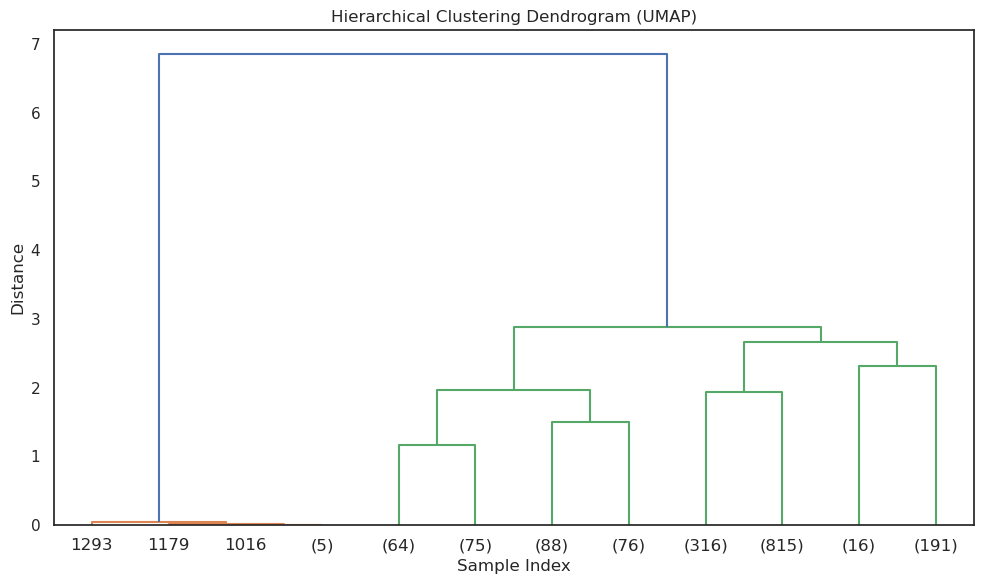

In [35]:
# calculate linkage matrix
from scipy.cluster.hierarchy import dendrogram, linkage

umap_linkage_matrix = linkage(X_umap, method='average')
fig, ax = plt.subplots(figsize=(10, 6))

#plot dendrogram
dendrogram(umap_linkage_matrix, ax=ax, truncate_mode='level', p=3)
ax.set_xlabel('Sample Index')
ax.set_ylabel('Distance')
ax.set_title('Hierarchical Clustering Dendrogram (UMAP)')

plt.tight_layout()
plt.show()

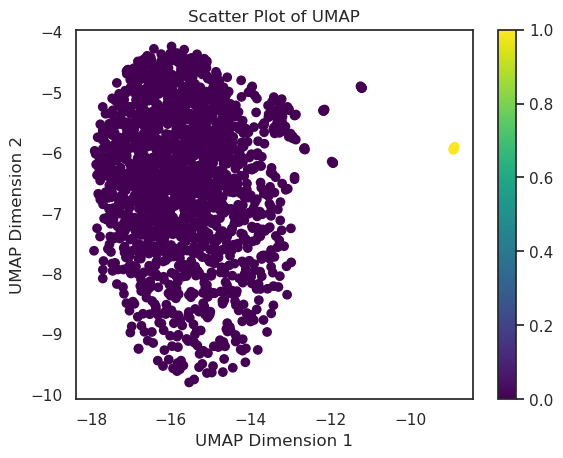

In [36]:

plt.scatter(X_umap[:, 0], X_umap[:, 1], c=labels, cmap='viridis')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.title('Scatter Plot of UMAP')
plt.colorbar()
plt.show()


# Creat result table of model comparison

In [37]:
import pandas as pd


kmeans_data = {
    'Algorithm' :'kmeans',
    'Dimensionality Reduction': ['pca', 'umap'],
    'n_clusters': [4, 3],
    'batch_size': [10, 50],
    'affinity': ['-', '-'],
    'linkage':  ['-', '-'],
    'Silhouette Coefficient Score': [-0.15526029183694287, 0.35250872],
    'Calinski-Harabasz Score': [1.0596117374004743, 991.6562901767062],
    'Davies-Bouldin Score': [1.0443445105722013, 0.9428124537245983]
}

agg_data = {
    'Algorithm' :'AgglomerativeClustering',
    'Dimensionality Reduction': ['pca', 'umap'],
    'n_clusters': [2, 2],
    'batch_size': ['-', '-'],
    'affinity': ['euclidean', 'euclidean'],
    'linkage': ['ward', 'average'],
    'Silhouette Coefficient Score': [0.6639138032018829, 0.6445255],
    'Calinski-Harabasz Score': [57.3959153166759, 99.27112465412901],
    'Davies-Bouldin Score': [0.3180584284289257, 0.2569101118953884]
}


kmeans_df = pd.DataFrame(kmeans_data)
agg_df = pd.DataFrame(agg_data)

# merge dataframe
df = pd.concat([kmeans_df, agg_df], ignore_index=True)

print(df)

                 Algorithm  降维方式  n_clusters batch_size   affinity  linkage  \
0                   kmeans   pca           4         10          -        -   
1                   kmeans  umap           3         50          -        -   
2  AgglomerativeClustering   pca           2          -  euclidean     ward   
3  AgglomerativeClustering  umap           2          -  euclidean  average   

   Silhouette Coefficient Score  Calinski-Harabasz Score  Davies-Bouldin Score  
0                     -0.155260                 1.059612              1.044345  
1                      0.352509               991.656290              0.942812  
2                      0.663914                57.395915              0.318058  
3                      0.644525                99.271125              0.256910  


In [38]:
! pip install openpyxl
df.to_excel('result.xlsx', index=None)


Defaulting to user installation because normal site-packages is not writeable
